In [4]:
# %reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']=".97"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
# from jax.config import config
from jax import config
# config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
#import pyccl as ccl
import pickle as pk
import scipy.interpolate as interp

%load_ext autoreload
%autoreload 2

import warnings

# Suppress RuntimeWarnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)



In [5]:
# import jax.numpy as jnp
# from jax import random
# x = random.uniform(random.PRNGKey(0), (1000,), dtype=jnp.float64)
# x.dtype # --> dtype('float64')
# x = jnp.array([1, 2, 3], dtype=jnp.float64)
# x.dtype
# x = jnp.logspace(0, 3, 100)




In [6]:
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 15.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.5

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = -5.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 1e-3, 18, 128
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 13.0, 14.5, 48
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 3, 7, 24
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True







In [7]:
from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)



In [57]:
import h5py as h5
fname = '/mnt/ceph/users/spandey/agora/create_galaxies/haloslc_agora_zsel_0_to_0.3_Msel_1e13_to_1e15_wvlos.h5'
f = h5.File(fname, 'r')
nsel = 200000
M_all = f['M'][:][:nsel]
ra_all = f['ra'][:][:nsel]
dec_all = f['dec'][:][:nsel]
z_all = f['z'][:][:nsel]
vlos_all = f['vlos'][:][:nsel]
f.close()
# M_all = f['M'][:]
# ra_all = f['ra'][:]
# dec_all = f['dec'][:]
# z_all = f['z'][:]



In [58]:
mock_params_dict = {}
mock_params_dict['halo_z'] = jnp.array(z_all)
mock_params_dict['halo_ra'] = jnp.array(ra_all)
mock_params_dict['halo_dec'] = jnp.array(dec_all)
mock_params_dict['halo_M'] = jnp.array(M_all)
mock_params_dict['halo_vlos'] = jnp.array(vlos_all)
mock_params_dict['nside'] = 128


In [30]:
halo_cat_scale_fac = 1./(1. + z_all)



In [31]:
import constants
import jax_cosmo.background as bkgrd
halo_cat_rho_c_z = constants.RHO_CRIT_0_KPC3 * bkgrd.Esqr(BCMP_test.cosmo_jax,halo_cat_scale_fac) * 1e9
mdef_delta=200
halo_cat_rho_treshold = mdef_delta * halo_cat_rho_c_z



In [32]:
halo_cat_R200c = (M_all * 3.0 / 4.0 / jnp.pi / halo_cat_rho_treshold)**(1.0 / 3.0)
halo_cat_DA = bkgrd.angular_diameter_distance(BCMP_test.cosmo_jax,halo_cat_scale_fac)
max_paint_R200c_factor = 3.


In [33]:
# import multiprocessing


In [34]:
# import numpy as np
# import healpy as hp
# import multiprocessing
# def hav(theta):
#     return np.sin(theta/2.)**2.

# def get_all_pix_data(jids, job_id, nearby_pix_all, distances_pix_all, logM_ind_all, z_ind_all):
#     for jhalo in jids:
#         vec = hp.ang2vec(ra_all[jhalo], dec_all[jhalo], lonlat=True)
#         nearby_angle = max_paint_R200c_factor*halo_cat_R200c[jhalo]/halo_cat_DA[jhalo]
#         nearby_pix = hp.query_disc(mock_params_dict['nside'], vec, nearby_angle)
#         nearby_ra, nearby_dec = hp.pix2ang(mock_params_dict['nside'], nearby_pix, lonlat=True)
        
#         ra1, dec1 = ra_all[jhalo]*np.pi/180., dec_all[jhalo]*np.pi/180.
#         ra2, dec2 = nearby_ra*np.pi/180., nearby_dec*np.pi/180.
#         theta = 2.*np.arcsin(np.sqrt(hav(dec1 - dec2) + np.cos(dec1)*np.cos(dec2)*hav(ra1-ra2)))
#         physical_distances_jhalo = halo_cat_DA[jhalo]*theta
#         nearby_pix_all.append(np.array(nearby_pix))
#         distances_pix_all.append(np.array(physical_distances_jhalo))
#         logM_ind_all.append(np.ones(len(nearby_pix))*np.log(M_all[jhalo]))
#         z_ind_all.append(np.ones(len(nearby_pix))*z_all[jhalo])



# import multiprocessing

# jid_all = np.arange(nsel)
# nproc = 16
# jid_split = np.array_split(jid_all, nproc)

# jobs = []
# manager = multiprocessing.Manager()
# nearby_pix_all = manager.list()
# distances_pix_all = manager.list()
# logM_ind_all = manager.list()
# z_ind_all = manager.list()

# for job_id in range(nproc):
#     jids = jid_split[job_id]
#     p = multiprocessing.Process(target=get_all_pix_data, args=(jids, job_id, nearby_pix_all, distances_pix_all, logM_ind_all, z_ind_all))
#     jobs.append(p)
#     p.start()

# for proc in jobs:
#     proc.join()

# nearby_pix_all = np.concatenate(nearby_pix_all)
# distances_pix_all = np.concatenate(distances_pix_all)
# logM_ind_all = np.concatenate(logM_ind_all)
# z_ind_all = np.concatenate(z_ind_all)




In [35]:
import healpy as hp
from tqdm import tqdm

# ra1, dec1 = ra_all[jhalo], dec_all[jhalo]
# ra2, dec2 = nearby_pix_ra_all[jhalo], nearby_pix_dec_all[jhalo]
# def hav(theta):
#     return jnp.sin(theta/2.)**2.

# theta = 2.*jnp.arcsin(jnp.sqrt(hav(dec1 - dec2) + jnp.cos(dec1)*jnp.cos(dec2)*hav(ra1-ra2)))
# physical_distances = halo_cat_DA[jhalo]*theta
# output_distances[jhalo] = physical_distances
import time
verbose = False

nearby_pix_all = []
distances_pix_all = []

nearby_pix_all_dict = {}
distances_pix_all_dict = {}

# nearby_pix_ra_all = []
# nearby_pix_dec_all = []
start_ind_all = []
end_ind_all = []

log10M_ind_all = []
z_ind_all = []


# for jhalo in ([0,1,2,3,4,5]):
# for jhalo in (range(1)):    
for jhalo in tqdm(range(len(z_all))):
    t0 = time.time()
    ti = time.time()
    vec = hp.ang2vec(ra_all[jhalo], dec_all[jhalo], lonlat=True)
    tf = time.time()
    if verbose:
        print('vec took: ', tf-ti)

    ti = time.time()
    nearby_angle = max_paint_R200c_factor*halo_cat_R200c[jhalo]/halo_cat_DA[jhalo]
    nearby_pix = hp.query_disc(mock_params_dict['nside'], vec, nearby_angle)
    tf = time.time()
    if verbose:
        print('query_disc took: ', tf-ti)

    ti = time.time()
    nearby_ra, nearby_dec = hp.pix2ang(mock_params_dict['nside'], nearby_pix, lonlat=True)
    tf = time.time()
    if verbose:
        print('pix2ang took: ', tf-ti)

    def hav(theta):
        return np.sin(theta/2.)**2.
    
    ra1, dec1 = ra_all[jhalo]*np.pi/180., dec_all[jhalo]*np.pi/180.
    ra2, dec2 = nearby_ra*np.pi/180., nearby_dec*np.pi/180.
    ti = time.time()
    theta = 2.*np.arcsin(np.sqrt(hav(dec1 - dec2) + np.cos(dec1)*np.cos(dec2)*hav(ra1-ra2)))
    tf = time.time()
    if verbose:
        print('theta took: ', tf-ti)

    physical_distances_jhalo = halo_cat_DA[jhalo]*theta
    # print(physical_distances_jhalo, len(physical_distances_jhalo))
    # print(len(physical_distances_jhalo))

    nearby_pix_all_dict[jhalo] = jnp.array(nearby_pix)
    distances_pix_all_dict[jhalo] = jnp.array(physical_distances_jhalo)
    ti = time.time()
    if jhalo == 0:
        start_ind = 0
        end_ind = len(nearby_pix)
        # nearby_pix_ra_all = jnp.array(nearby_ra)
        # nearby_pix_dec_all = jnp.array(nearby_dec)
        nearby_pix_all = np.array(nearby_pix)
        distances_pix_all = np.array(physical_distances_jhalo)
        start_ind_all = np.array([start_ind])
        end_ind_all = np.array([end_ind])
        logM_ind_all = np.ones(len(nearby_pix))*np.log(M_all[jhalo])
        z_ind_all = np.ones(len(nearby_pix))*z_all[jhalo]
    else:
        start_ind = end_ind_all[-1]
        end_ind = start_ind + len(nearby_pix)
        # nearby_pix_ra_all = jnp.concatenate([nearby_pix_ra_all, jnp.array(nearby_ra)])
        # nearby_pix_dec_all = jnp.concatenate([nearby_pix_dec_all, jnp.array(nearby_dec)])
        nearby_pix_all = np.concatenate([nearby_pix_all, np.array(nearby_pix)])
        distances_pix_all = np.concatenate([distances_pix_all, np.array(physical_distances_jhalo)])
        start_ind_all = np.concatenate([start_ind_all, np.array([start_ind])])
        end_ind_all = np.concatenate([end_ind_all, np.array([end_ind])])
        logM_ind_all = np.concatenate([logM_ind_all, np.ones(len(nearby_pix))*np.log(M_all[jhalo])])
        z_ind_all = np.concatenate([z_ind_all, np.ones(len(nearby_pix))*z_all[jhalo]])
    tf = time.time()
    if verbose:
        print('concat took: ', tf-ti)
        print('total time: ', tf - t0)
        print('\n')
    # nearby_pix_all[jhalo] = jnp.array(nearby_pix)
    # nearby_pix_ra_all[jhalo] = jnp.array(nearby_ra)
    # nearby_pix_dec_all[jhalo] = jnp.array(nearby_dec)




  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [06:21<00:00, 523.75it/s]


In [53]:
# import multiprocessing
# print(multiprocessing.cpu_count())
# !pip install healpix
# import healpix
jhalo = 100
vec = hp.ang2vec(ra_all[jhalo], dec_all[jhalo], lonlat=True)
nearby_angle = 0.1*max_paint_R200c_factor*halo_cat_R200c[jhalo]/halo_cat_DA[jhalo]
print(nearby_angle)
hp.query_disc(mock_params_dict['nside'], vec, nearby_angle)




0.00430136263792179


array([94458])

In [43]:
# vec = healpix.ang2vec(ra_all[jhalo], dec_all[jhalo], lonlat=True)
nearby_pix = healpix.query_disc(mock_params_dict['nside'], vec, nearby_angle)



AttributeError: module 'healpix' has no attribute 'query_disc'

In [13]:
# distances_pix_all.shape, nearby_pix_all.shape, start_ind_all.shape
# theta
# halo_cat_DA[jhalo]
# nearby_angle
# theta




In [36]:
# mock_params_dict['nearby_pix_all'] = nearby_pix_all_dict
# mock_params_dict['distance_nearby_all'] = distances_pix_all_dict

mock_params_dict['nearby_pix_all'] = jnp.array(nearby_pix_all)
# mock_params_dict['distance_nearby_all'] = jnp.array(distances_pix_all)
# mock_params_dict['log10M_ind_all'] = jnp.array(log10M_ind_all)
# mock_params_dict['z_ind_all'] = jnp.array(z_ind_all)
mock_params_dict['pix_prop_all'] = jnp.array([np.log(distances_pix_all), z_ind_all, logM_ind_all]).T
mock_params_dict['start_ind'] = jnp.int32(jnp.array(start_ind_all))
mock_params_dict['end_ind'] = jnp.int32(jnp.array(end_ind_all))

# mock_params_dict['start_ind'] = (start_ind_all)
# mock_params_dict['end_ind'] = (end_ind_all)


In [37]:
# jnp.array([np.log(distances_pix_all), z_ind_all, logM_ind_all])


# distances_pix_all.shape, z_ind_all.shape, logM_ind_all.shape
# mock_params_dict['pix_prop_all'].shape


In [38]:
from get_sim_on_halos_jit import get_mock_map
mock_map_test = get_mock_map(sim_params_dict, halo_params_dict, mock_params_dict, BCMP_obj=BCMP_test)




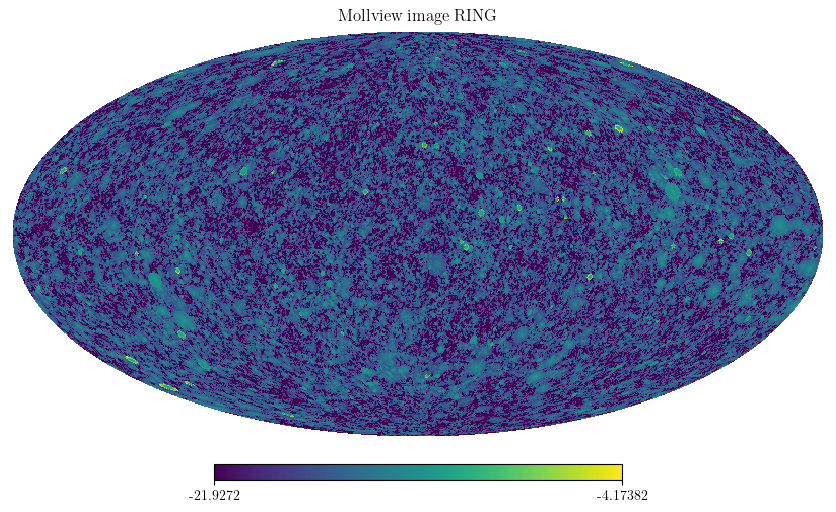

In [39]:
hp.mollview(np.log(mock_map_test.ymap_final+3e-10), title="Mollview image RING")




In [48]:
pix_halos = hp.ang2pix(mock_params_dict['nside'], ra_all[::3], dec_all[::3], lonlat=True)
map_halos = np.zeros(hp.nside2npix(mock_params_dict['nside']))
map_halos[pix_halos] = 1



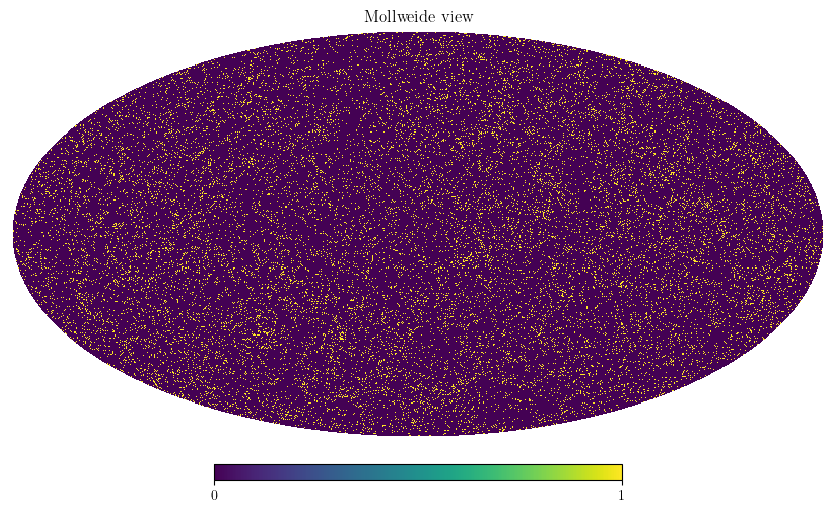

In [49]:
hp.mollview(map_halos)



In [39]:
# # len(nearby_pix_all), len(np.unique(nearby_pix_all))
# yjpix_all = mock_map_test.yjpix_all
# # indices_all = nearby_pix_all

# pix_unique, indices_unique, indices_inverse, indices_counts = np.unique(nearby_pix_all, return_index=True, return_inverse=True, return_counts=True)



In [40]:
# indices_iverse
# pix_unique
# indices_unique
# nearby_pix_all.shape, indices_counts.shape, pix_unique.shape
# indices_counts
# len(np.where(indices_counts > 1)[0])
# np.amax(indices_counts)
# nearby_pix_all



In [41]:
sort_index_nearby_pix_all = np.argsort(nearby_pix_all)
sorted_nearby_pix_all = nearby_pix_all[sort_index_nearby_pix_all]
ypix_all_sorted = yjpix_all[sort_index_nearby_pix_all]

# if any values are repeated in sorted_nearby_pix_all, sum the ypix_all_sorted values for those indices:




In [42]:
change_points = np.diff(sorted_nearby_pix_all, prepend=sorted_nearby_pix_all[0]-1, append=sorted_nearby_pix_all[-1]+1) != 0 
boundaries = np.where(change_points)[0]



In [43]:
# change_points
boundaries

array([      0,       1,       4, ..., 1223136, 1223137, 1223138])

In [44]:
group_sums = np.add.reduceat(ypix_all_sorted, boundaries[:-1])



In [45]:
# group_sums.shape, pix_unique.shape
ymap_new = np.zeros(12 * mock_params_dict['nside']**2)
ymap_new[pix_unique] = group_sums


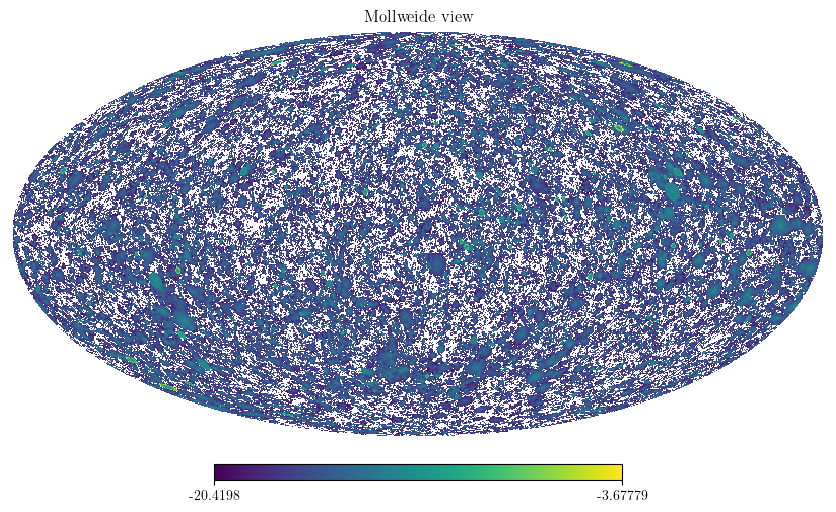

In [46]:
# mock_map_test.y_sim
hp.mollview(np.log(ymap_new))


In [63]:
# mock_map_test.run
# distances_pix_all[0]


80.72238633357348

In [36]:
# # mock_map_test.run
# jrp, jz, jM = 5, 0, 0
# num_trapz_points=32
# cval_jM_jz = mock_map_test.conc_Mz_mat[jz, jM]
# jc = jnp.argmin(jnp.abs(mock_map_test.c_array - cval_jM_jz))
# rp = mock_map_test.rp_array[jrp]
# r_array_here = jnp.exp(jnp.linspace(jnp.log(rp*1.01), jnp.log(jnp.max(mock_map_test.r_array)), num_trapz_points))
# Pe_rarray_here = jnp.exp(jnp.interp(jnp.log(r_array_here), jnp.log(mock_map_test.r_array), jnp.log(mock_map_test.Pe_mat_physical[:,jc, jz, jM])))
# num = r_array_here * Pe_rarray_here
# denom = jnp.sqrt(r_array_here ** 2 - rp ** 2)
# toint = num / denom
# val = 2. * jnp.trapz(toint * r_array_here, jnp.log(r_array_here))




In [41]:
# r_array_here
# Pe_rarray_here

# val

In [42]:
# val
# toint
# num
# mock_map_test.Pe_mat_physical[:,jc, jz, jM]



In [57]:
# mock_map_test.halo_cat_z.shape

mock_map_test.run



Array([inf, inf, inf, ..., inf, inf, inf], dtype=float64)

In [51]:
from jax import jit
import jax

# @jit
# def numpy_callback(x):
  # Need to forward-declare the shape & dtype of the expected output.
#   result_shape = jax.core.ShapedArray(x.shape, x.dtype)
#   return jax.pure_callback(np.sin, result_shape, x)




In [60]:
mock_map_test.y2D_mat_physical.shape

# numpy_callback(mock_map_test.y_sim)


(124, 3, 48)

In [62]:
# mock_map_test.y2D_mat_physical[:,0,0]

# mock_map_test.log_y2D_interp


Array([9.60570324e-08, 9.60009560e-08, 9.58927822e-08, 9.57926363e-08,
       9.56690289e-08, 9.55195225e-08, 9.53562393e-08, 9.51705248e-08,
       9.49591952e-08, 9.47253846e-08, 9.44667580e-08, 9.41804308e-08,
       9.38687596e-08, 9.35259577e-08, 9.31537818e-08, 9.27528034e-08,
       9.23171204e-08, 9.18506714e-08, 9.13521974e-08, 9.08182328e-08,
       9.02484092e-08, 8.96432169e-08, 8.90014198e-08, 8.83241854e-08,
       8.76105916e-08, 8.68598421e-08, 8.60725950e-08, 8.52525584e-08,
       8.43940831e-08, 8.35043283e-08, 8.25816196e-08, 8.16160222e-08,
       8.06425826e-08, 7.96054152e-08, 7.85584907e-08, 7.74669270e-08,
       7.63517020e-08, 7.52019696e-08, 7.40224418e-08, 7.28111589e-08,
       7.15680231e-08, 7.02926010e-08, 6.89837998e-08, 6.76440589e-08,
       6.62693498e-08, 6.48629446e-08, 6.34235349e-08, 6.19517621e-08,
       6.04507404e-08, 5.89161327e-08, 5.73510221e-08, 5.57550138e-08,
       5.41321202e-08, 5.24819060e-08, 5.08063563e-08, 4.91070827e-08,
      

In [22]:
hp.mollview(np.array(mock_map_test.y_sim))



TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[786432].
This DynamicJaxprTracer was created on line /mnt/ceph/users/spandey/GODMAX/src/get_sim_on_halos_jit.py:236:21 (get_mock_map.get_Pe_healpix)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [24]:
np.array(mock_map_test.y_sim)



TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[786432].
This DynamicJaxprTracer was created on line /mnt/ceph/users/spandey/GODMAX/src/get_sim_on_halos_jit.py:236:21 (get_mock_map.get_Pe_healpix)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError